# Second order stochastic methods for CryoEM

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.algorithm import oasis, oasis_adaptive
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [3]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles: 105519
load_data: data loaded, time:  73.25 sec.


In [4]:
out_dir = out_dir = '../data/out_dev/'

In [5]:
nx0 = imgs0.shape[1]
nx_crop = 128
N = 80000
N_px_noise = 48
N_imgs_noise=1000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop, N = N, N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

imgs0.shape = (105519, 320, 320)
pixel_size0.shape = (105519,)
angles0.shape = (105519, 3)
shifts0.shape = (105519, 2)
ctf_params0.shape = (105519, 9)
Shuffle = False
N = 80000
Taking FFT of the images:
Batch 1/10  21.66 sec.
Batch 2/10  21.78 sec.
Batch 3/10  21.72 sec.
Batch 4/10  21.74 sec.
Batch 5/10  23.99 sec.
Batch 6/10  24.01 sec.
Batch 7/10  23.61 sec.
Batch 8/10  24.06 sec.
Batch 9/10  24.01 sec.
Batch 10/10  23.70 sec.
FFT done. Time:  282.08 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 1.28000000e+02]
Vectorised imgs_f.shape = (80000, 16384)
Mask radius = 0.1502862595419847
Estimating the noise using the 48 x 48 corners of the first 1000 images.
Estimating pixel-wise noise...done.
Averaging radially...done.
Noise estimation done. Time:  20.60 sec.


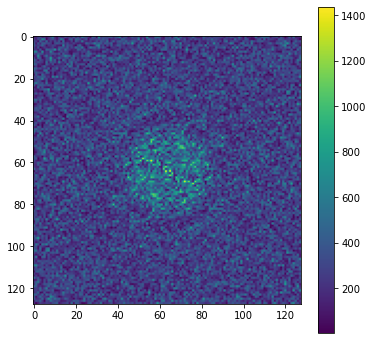

In [6]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[2135].reshape([128,128]))));plt.colorbar()

In [7]:
del(imgs0)

### Only volume reconstruction for now - SGD

Obervations:

* The loss and grad don't tell us anything about convergence. The loss is about the same after only 100 iterations and after 10 epochs (of 781 iters each), and yet the result is different

In [8]:
# Apply mask to images
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [9]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [10]:
alpha = 1e-9

slice_obj = Slice(x_grid)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

#### SGD

In [169]:
idxrand = np.random.permutation(N)
idx1 = idxrand[:int(N/2)]
idx2 = idxrand[int(N/2):]
             

In [170]:
angles1 = angles[idx1]
shifts1 = shifts[idx1]
ctf_params1 = ctf_params[idx1]
imgs1 = imgs_f[idx1]

angles2 = angles[idx2]
shifts2 = shifts[idx2]
ctf_params2 = ctf_params[idx2]
imgs2 = imgs_f[idx2]

TODO:

* Add the hvpFidx function to the get_sgd_ops
* Each subset requires a separate preconditioner

In [252]:
def hvp_loss_func(v, x, angles, shifts, ctf_params, imgs, sigma_noise):
    return jax.jvp(lambda u : gradv_obj.grad_loss_volume_sum(u, angles, shifts, ctf_params, imgs, sigma_noise), (v,), (x,))[1]

Fidx = lambda v, idx : loss_obj.loss_sum(v, angles1[idx,:], shifts1[idx,:], ctf_params1[idx,:], imgs1[idx,:], sigma_noise)
gradFidx = lambda v, idx : gradv_obj.grad_loss_volume_sum(v, angles1[idx,:], shifts1[idx,:], ctf_params1[idx,:], imgs1[idx,:], sigma_noise)
hvpFidx1 = lambda v, x, idx : hvp_loss_func(v, x, angles1[idx,:], shifts1[idx,:], ctf_params1[idx,:], imgs1[idx,:], sigma_noise)

hvpFidx2 = lambda v, x, idx : hvp_loss_func(v, x, angles2[idx,:], shifts2[idx,:], ctf_params2[idx,:], imgs2[idx,:], sigma_noise)


In [253]:
Fidx(v_rec1, [0])

DeviceArray(6023.38583189, dtype=float64)

In [176]:

iters = 2000
batch_sz = 100
key, *subkeys = random.split(key, 2*iters+1)

zD0z = np.zeros([nx,nx,nx])

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], [nx,nx,nx], dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N//2)[:batch_sz]
    
    zD0z += z * hvpFidx1(x0, z, idx)
    
D01 = jnp.array(zD0z/iters)

100%|██████████| 2000/2000 [01:49<00:00, 18.30it/s]


In [177]:

iters = 2000
batch_sz = 100
key, *subkeys = random.split(key, 2*iters+1)

zD0z = np.zeros([nx,nx,nx])

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], [nx,nx,nx], dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N//2)[:batch_sz]
    
    zD0z += z * hvpFidx2(x0, z, idx)
    
D02 = jnp.array(zD0z/iters)

100%|██████████| 2000/2000 [01:49<00:00, 18.23it/s]


In [221]:
N_epochs = 20
batch_size = 32
step_size = 1e-2 #1000000 # 1e-3


grad_func1, loss_func1 = get_sgd_vol_ops(gradv_obj, loss_obj, angles1, shifts1, ctf_params1, imgs1, sigma_noise)
grad_func2, loss_func2 = get_sgd_vol_ops(gradv_obj, loss_obj, angles2, shifts2, ctf_params2, imgs2, sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [ ]:
v_rec1, loss_rec1, grad_rec1 = sgd(grad_func1, loss_func1, N//2, x0, step_size, N_epochs, batch_size, P = 1/D01, verbose=True, iter_display=1)


Epoch 1/20 

 50%|█████     | 630/1250 [00:24<00:22, 27.14it/s, grad=2.962e-04, loss=5.871e+03]

In [ ]:
v_rec2, loss_rec2, grad_rec2 = sgd(grad_func2, loss_func2, N//2, x0, step_size, N_epochs, batch_size, P=1/D02, verbose=True, iter_display=1)


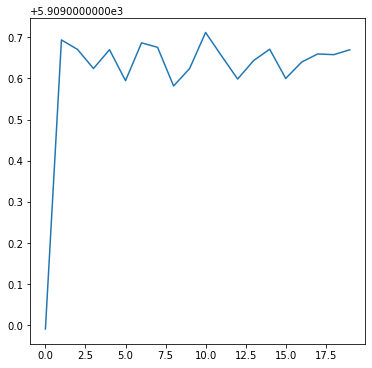

In [249]:
plt.plot(loss_rec2)

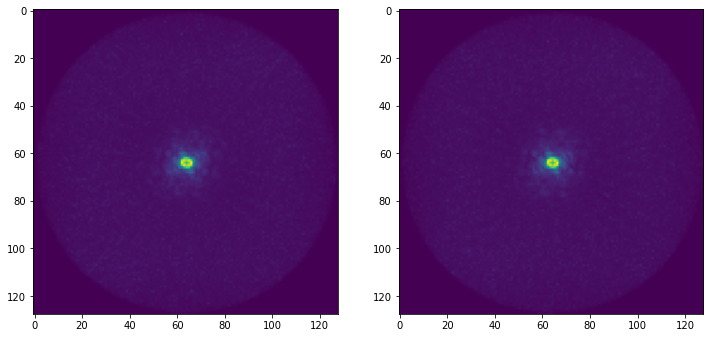

In [236]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec1))); #plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec2))); #plt.colorbar()

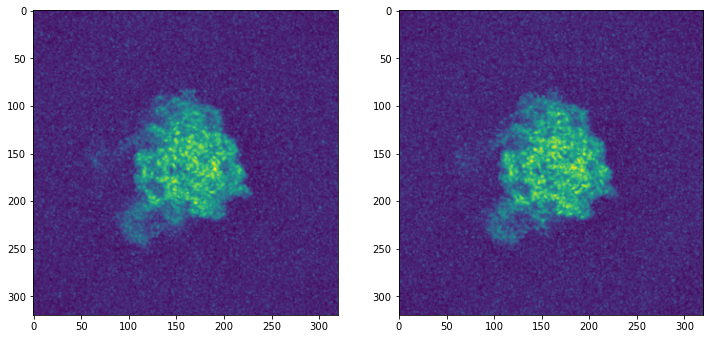

In [237]:
v_rec_l1, _ = rescale_larger_grid(v_rec1, x_grid, nx0)
vr_sgd1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l1)))

v_rec_l2, _ = rescale_larger_grid(v_rec2, x_grid, nx0)
vr_sgd2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l2)))

plt.subplot(1,2,1)
mip_z(vr_sgd1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_sgd2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [238]:
with mrcfile.new(f"{out_dir}/v_rec_sgd1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_sgd2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd2.astype(np.float32))   

#### OASIS

### Something is wrong here:

* The OASIS reconstruction is flipped compared to the SGD one - why
* Also the OASIS rec with fixed rate should be the same as SGD with D0 preconditioner, so the loss and results should be the same. What's wrong? For some reason the object stays very low resolution
* Work with a dataset with no heterogeneity

In [148]:
idxrand = np.random.permutation(N)
idx1 = idxrand[:int(N/2)]
idx2 = idxrand[int(N/2):]
             
key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [149]:
angles1 = angles[idx1]
shifts1 = shifts[idx1]
ctf_params1 = ctf_params[idx1]
imgs1 = imgs_f[idx1]

angles2 = angles[idx2]
shifts2 = shifts[idx2]
ctf_params2 = ctf_params[idx2]
imgs2 = imgs_f[idx2]

In [254]:
def hvp_loss_func(v, x, angles, shifts, ctf_params, imgs, sigma_noise):
    return jax.jvp(lambda u : gradv_obj.grad_loss_volume_sum(u, angles, shifts, ctf_params, imgs, sigma_noise), (v,), (x,))[1]

Fidx = lambda v, idx : loss_obj.loss_sum(v, angles1[idx,:], shifts1[idx,:], ctf_params1[idx,:], imgs1[idx,:], sigma_noise)
gradFidx = lambda v, idx : gradv_obj.grad_loss_volume_sum(v, angles1[idx,:], shifts1[idx,:], ctf_params1[idx,:], imgs1[idx,:], sigma_noise)
hvpFidx = lambda v, x, idx : hvp_loss_func(v, x, angles1[idx,:], shifts1[idx,:], ctf_params1[idx,:], imgs1[idx,:], sigma_noise)



In [256]:
Fidx(v_rec1, [0])

DeviceArray(6023.38583189, dtype=float64)

In [151]:
#D0 = jnp.ones((nx,nx,nx))  #<--- not very good

iters = 200
batch_sz = 100
key, *subkeys = random.split(key, 2*iters+1)

zD0z = np.zeros([nx,nx,nx])

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], [nx,nx,nx], dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N//2)[:batch_sz]
    
    zD0z += z * hvpFidx(x0, z, idx)
    
D0 = jnp.array(zD0z/iters)

100%|██████████| 200/200 [00:10<00:00, 18.24it/s]


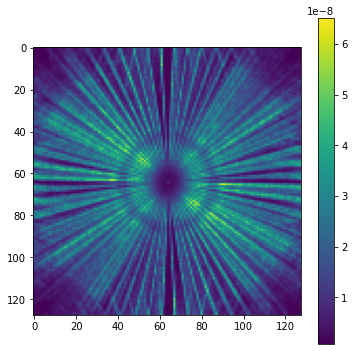

In [152]:
plt.imshow(jnp.fft.fftshift(jnp.abs(D0[:,:,0]))); plt.colorbar()

In [164]:
N_epoch = 1
beta2 = 1 #0.99
eta0 = 1e-4 #0.0001 #0.1/0.001/0.01/0.15
batch_size = 32
alpha = 1e-15 #0.1 # 0.01

In [165]:
key, subkey = random.split(key)
v_rec_o1, loss_o1 = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta0, D0, beta2, alpha, N_epoch, batch_size = batch_size, N = N//2, iter_display = 1)


Epoch 1/1


100%|██████████| 1250/1250 [01:26<00:00, 14.47it/s, loss=6.177e+03]


  Loss =  6.194e+03


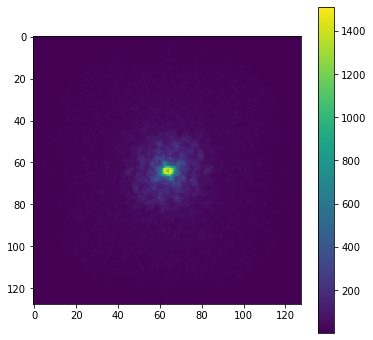

In [166]:
mip_z(np.fft.fftshift(np.abs(v_rec_o1))); 
plt.colorbar()

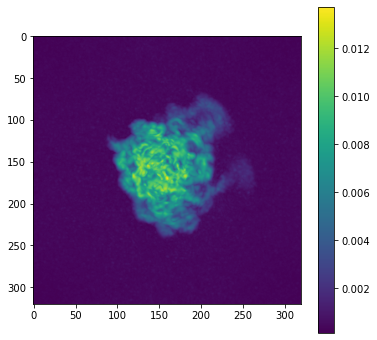

In [167]:
v_rec_ol1, _ = rescale_larger_grid(v_rec_o1, x_grid, nx0)
vr_o1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol1)))

mip_z(vr_o1)
plt.colorbar()

In [168]:
with mrcfile.new(f"{out_dir}/v_rec_o1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o1.astype(np.float32))
    

#### FSC

In [239]:
print(v_rec1.shape)
print(v_rec2.shape)
print(x_grid)

(128, 128, 128)
(128, 128, 128)
[2.38549618e-03 1.28000000e+02]


In [240]:
res, fsc, shell_points = calc_fsc(v_rec1, v_rec2, [1, 128])

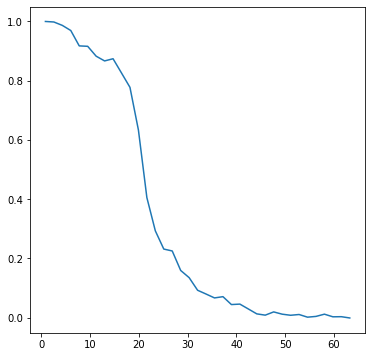

In [241]:
plt.plot(res, fsc)

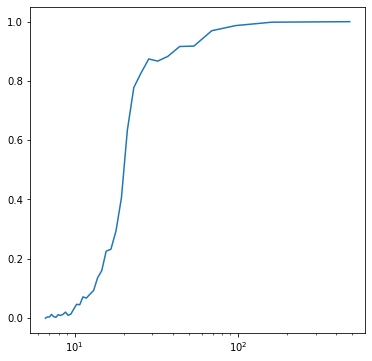

In [242]:
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc)

In [243]:
fsc

DeviceArray([ 1.        ,  0.99821482,  0.98674142,  0.96942508,
              0.91753482,  0.91612029,  0.88278295,  0.8667659 ,
              0.87414504,  0.82598732,  0.77755767,  0.63351511,
              0.40530615,  0.29307211,  0.23155315,  0.22509709,
              0.15930956,  0.13501673,  0.09246622,  0.07970092,
              0.06659881,  0.07081206,  0.04415857,  0.04572322,
              0.02929544,  0.01273705,  0.00841998,  0.01935923,
              0.01172507,  0.00800317,  0.01059125,  0.00159735,
              0.00416199,  0.01171249,  0.00283357,  0.00321735,
             -0.00111937], dtype=float64)

In [244]:
fsc[11]

DeviceArray(0.63351511, dtype=float64)

In [245]:
fsc[12]

DeviceArray(0.40530615, dtype=float64)

In [246]:
res_angs[11]

DeviceArray(21.04567242, dtype=float64)

In [247]:
res_angs[12]

DeviceArray(19.36201863, dtype=float64)

### Newton's method vs GD vs CG

#### GD - a pain to tune 

In [ ]:
Ngd = 1000

N_epochs = 200
batch_size = Ngd
step_size = 10000 # 1e-3

idx = np.arange(Ngd)

grad_func, loss_func = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [ ]:
v_rec_gd, loss_rec_gd, grad_rec_gd = sgd(grad_func, loss_func1, Ngd, x0, step_size, N_epochs, batch_size, verbose=True, iter_display=10)


In [ ]:
plt.plot(loss_rec_gd)

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

In [ ]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [ ]:
key, subkey = random.split(key)

A = random.normal(subkey, (n,n))
A = A.T + A

plt.imshow(A); plt.colorbar()

In [ ]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

#z * A @ z 

In [ ]:
zAz = jax.vmap(lambda zi : zi * (A @ zi))(z)
#plt.imshow(zAz)

In [ ]:
d = np.zeros((iters, n))
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i-1] + zAz[i]
    
for i in range(1, iters):
    d[i] = d[i]/(i+1)

In [ ]:
err = jnp.mean((d - jnp.diag(A))**2, axis=1)

In [ ]:
plt.semilogy(err)

#### Hessian-vector product in JaX

In [ ]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [ ]:
b = A @ x0 
f = lambda x : jnp.mean((A @ x - b)**2)

In [ ]:
f(x0)

In [11]:
from jax import jvp, grad

# Naive
def hvp0(f, x, v):
    return grad(lambda x : jnp.vdot(grad(f)(x), v))(x)

# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [ ]:
t0 = time.time()
v1 = hvp0(f, x, v).block_until_ready()
print(time.time()-t0)

t0 = time.time()
v2 = hvp(f, (x,), (v,)).block_until_ready()
print(time.time()-t0)

jnp.sum(jnp.abs(v1-v2))

#### Toy problem

In [ ]:
key, *subkey = random.split(key, 4)

x_gt = random.normal(subkey[0], (n,))

A = np.random.normal(size = (n,n))
A = A.T @ A
_, v = jnp.linalg.eigh(A)
d = jnp.flip(jnp.logspace(-5,1,n)) 
d = d + jnp.abs(jnp.min(d)*2)
A = v.T @ jnp.diag(d) @ v

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort(evals))


assert(jnp.sum(evals < 0) == 0)
#assert(jnp.max(jnp.abs(A.T - A)) == 0)
#assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)


plt.semilogy(evals, '.')
plt.title("Eigenvalues")
print(f"Condition number = {evals[0]/evals[n-1] : .2e}")

In [ ]:
sig_noise = 1
lam = 0.1

b = A @ x_gt  + np.random.normal(size=(n,)) * sig_noise

F = jax.jit(lambda x : jnp.sum((A @ x - b)**2) + lam * jnp.mean(x**2))
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.jit(jax.grad(F))
hessianF = jax.hessian(F)

hvpF = jax.jit(lambda x, v : hvp(F, (x,), (v,)))

print(f"gradF(x_gt) = {gradF(x_gt)}")
print(f"hessianF(x_gt) = {hessianF(x_gt)}")


In [ ]:
def gd(F, gradF, eta, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        w1 = w0 - eta * gradF(w0)
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

def newton(F, gradF, hessianF, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        G = gradF(w0)
        H = hessianF(w0)
        
        w1 = w0 - jnp.linalg.inv(H) @ G
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

In [ ]:
N_iter = 10000
eta = 1e-3 #0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display = 200)

In [ ]:
plt.semilogy(loss_gd)

In [ ]:
N_iter = 10

x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

In [ ]:
plt.plot(loss_n)

In [ ]:
N_iter = 10000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = jax.jit(lambda vv : jnp.conj(gradF(vv)) + Ab)

x_cg, kk = cg(AA, Ab, x0, N_iter, verbose=True)

In [ ]:
F(x_cg)

#### OASIS

In [ ]:
Fidx = jax.jit(lambda x, idx : F(x))
gradFidx = jax.jit(lambda x, idx : jax.grad(F)(x))
hvpFidx = jax.jit(lambda x, v, idx : hvp(F, (x,), (v,)))

In [ ]:
# Estimating D0

iters = 100
key, *subkeys = random.split(key, iters+1)
zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[i], (n,), dtype=x0.dtype)
    
    zD0z += z * hvpFidx(x0, z, 1)
    
D0 = jnp.array(zD0z/iters)

D0exact = jnp.diag(hessianF(x0)) # Cheating a bit


In [ ]:
plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [ ]:
N_iter = 10000
beta2 = 0.99
eta = 0.01 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_iter, iter_display = 500)


In [ ]:
N_iter = 10000
beta2 = 0.99
eta0 = 0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta0, D0, beta2, alpha, N_iter, iter_display = 500)


In [ ]:
print(jnp.max(jnp.abs(x_gt-x_n)))
print(jnp.max(jnp.abs(x_gt-x_cg)))
print(jnp.max(jnp.abs(x_gt-x_gd)))
print(jnp.max(jnp.abs(x_gt-x_o)))
print(jnp.max(jnp.abs(x_gt-x_oa)))

plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)

nn0 = 0
nn1 = 2000
#plt.semilogy(loss_n[nn0:nn1])
plt.semilogy(loss_gd[nn0:nn1])
plt.semilogy(loss_o[nn0:nn1])
plt.semilogy(loss_oa[nn0:nn1])
#plt.legend(["Newton", "GD", "OASIS", "OASIS adaptive"])
plt.legend(["GD", "OASIS", "OASIS adaptive"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_gt-x_n))
plt.semilogy(jnp.abs(x_gt-x_gd))
plt.semilogy(jnp.abs(x_gt-x_o))
plt.semilogy(jnp.abs(x_gt-x_oa))
plt.legend(["Newton", "GD", "OASIS", "OASIS_adaptive"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6, 6

### Stochastic - sum of operators

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

Generate $N$ operators to create a loss function to do SGD/OASIS on:

In [ ]:
sig_noise = 10
lam = 0.1

In [ ]:
n = 100
N = 1000

x_gt = np.random.normal(size=(n,))

ops = []
b = []
for i in range(N):
    A = np.random.normal(size=(n,n))
    A = A.T @ A
    _, v = jnp.linalg.eigh(A)
    
    d = jnp.flip(jnp.logspace(-5,4,n)) + np.random.normal(size=(n,))*10 
    d = d + jnp.abs(jnp.min(d)*2)
                 
    A = v.T @ jnp.diag(d) @ v
    ops.append(A)
    
    bn = A @ x_gt + np.random.normal(size=(n,)) * sig_noise
    b.append(bn)
    
    #print(jnp.mean((A@x_gt - bn)**2))
    
ops = jnp.array(ops)
b = jnp.array(b)

In [ ]:
w, _ = jnp.linalg.eigh(A)
w = jnp.flip(jnp.sort(w))
print(f"{jnp.max(w)/jnp.min(w) : .2e}")

In [ ]:
def loss_term(x, A, b):
    return 1/2 * jnp.mean((A@x - b)**2) + lam * jnp.mean(x**2)

def loss_func(x, ops, b):
    return jnp.mean(jax.vmap(loss_term, in_axes = (None, 0, 0))(x, ops, b))

def grad_loss_func(x, ops, b):
    return jax.grad(loss_func)(x, ops, b)

def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y : grad_loss_func(y, ops, b), (x,), (v,))[1]

In [ ]:
idx = np.random.permutation(N)[:N//3]

print(loss_term(x_gt, ops[0], b[0]))
print(loss_func(x_gt, ops, b))

print(grad_loss_func(x_gt, ops, b).shape)
print(grad_loss_func(x_gt, ops[idx], b[idx]).shape)

print(hvp_loss_func(x_gt, x_gt, ops, b).shape)
print(hvp_loss_func(x_gt, x_gt, ops[idx], b[idx]).shape)

In [ ]:
hessianF = lambda x : jax.hessian(loss_func)(x, ops, b)

Fidx = jax.jit(lambda x, idx : loss_func(x, ops[idx], b[idx]))
gradFidx = jax.jit(lambda x, idx : grad_loss_func(x, ops[idx], b[idx]))
hvpFidx = jax.jit(lambda x, v, idx : hvp_loss_func(x, v, ops[idx], b[idx]))
x0 = jnp.array(np.random.randn(n))

In [ ]:
Fidx(x_gt, jnp.arange(N))

In [ ]:
#D0 = jnp.ones((nx,nx,nx))  #<--- not very good

iters = 100
batch_sz = 32
key, *subkeys = random.split(key, 2*iters+1)

zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], (n,), dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N)[:batch_sz]
    
    zD0z += z * hvpFidx(x0, z, idx)
    
D0 = jnp.array(zD0z/iters)

D0exact = jnp.diag(hessianF(x0)) # Cheating a bit


In [ ]:
plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_os, loss_os = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_osa, loss_osa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


In [ ]:
N_epoch = 10
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)

In [ ]:
N_epoch = 10
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)


In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-6
                       
key, subkey = random.split(key)
x_sgd, loss_sgd, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, verbose = True, iter_display = 1)

In [ ]:
plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)
plt.semilogy(loss_sgd)
#plt.semilogy(loss_o)
plt.semilogy(loss_os)
#plt.semilogy(loss_oa)
plt.semilogy(loss_osa)
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_sgd-x_gt))
#plt.semilogy(jnp.abs(x_o-x_gt))
plt.semilogy(jnp.abs(x_os-x_gt))
#plt.semilogy(jnp.abs(x_oa-x_gt))
plt.semilogy(jnp.abs(x_osa-x_gt))
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

Next:

* ~~Run the new OASIS algorithms on the old (deterministic one operator) toy problem~~
* ~~Implement the adaptive version of the stochastic OASIS~~
* ~~Add noise and rerun all the experiments~~
* In the stochastic toy problem case, also compare with CG (make the problem small enough so that we can do CG)
* ~~Implement some kind of warm up /estimation of $D_0$~~
* Run on CryoEM data